# CNN (CIFAR10)
## 1. Library, Data Preprocessing 
## 2. Solve classification with Pytorch
## 3. Show the result 

# Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset # for loading dataset (mnist)
import torchvision.transforms as transforms # for processing datasets
from torch.utils.data import DataLoader # for making dataset easier to use 

from matplotlib import pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: gpu") if torch.cuda.is_available() else print("device: cpu")

device: gpu


# Hyper parameter setting

In [2]:
# hypter parameter setting
learning_rate = 1e-4
training_epochs = 100
display_step = 10
batch_size = 32
momentum = 0.9 # 이전의 gradient 정보를 갖고 반영해준다.

activation = nn.ReLU()
max_pool = nn.MaxPool2d(2,2) # kerel size, stride size, padding size 

# Load data & Pre-process data

Files already downloaded and verified
Files already downloaded and verified
len(train_data):  50000
len(test_data):  10000
data tensor([[[0.2314, 0.2431, 0.2471],
         [0.1686, 0.1804, 0.1765],
         [0.1961, 0.1882, 0.1686],
         ...,
         [0.6196, 0.5176, 0.4235],
         [0.5961, 0.4902, 0.4000],
         [0.5804, 0.4863, 0.4039]],

        [[0.0627, 0.0784, 0.0784],
         [0.0000, 0.0000, 0.0000],
         [0.0706, 0.0314, 0.0000],
         ...,
         [0.4824, 0.3451, 0.2157],
         [0.4667, 0.3255, 0.1961],
         [0.4784, 0.3412, 0.2235]],

        [[0.0980, 0.0941, 0.0824],
         [0.0627, 0.0275, 0.0000],
         [0.1922, 0.1059, 0.0314],
         ...,
         [0.4627, 0.3294, 0.1961],
         [0.4706, 0.3294, 0.1961],
         [0.4275, 0.2863, 0.1647]],

        ...,

        [[0.8157, 0.6667, 0.3765],
         [0.7882, 0.6000, 0.1333],
         [0.7765, 0.6314, 0.1020],
         ...,
         [0.6275, 0.5216, 0.2745],
         [0.2196, 0.1216, 

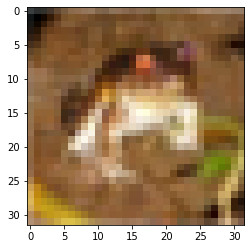

In [3]:
# load data
train_data = dataset.CIFAR10("./", train = True, transform = transforms.ToTensor(), target_transform = None, download = True)
test_data = dataset.CIFAR10("./", train = False, transform = transforms.ToTensor(), target_transform = None, download = True)

# check the data
print('len(train_data): ', len(train_data))
print('len(test_data): ', len(test_data))

x_train, y_train = train_data[0]
x_train = np.transpose(x_train, (1, 2, 0))

print('data', x_train)
print('data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train)
plt.show()

data shape: torch.Size([32, 3, 32, 32])
label: tensor([0, 4, 9, 4, 3, 9, 6, 1, 8, 0, 7, 4, 7, 4, 8, 0, 3, 4, 4, 4, 5, 2, 5, 2,
        0, 5, 5, 9, 3, 8, 0, 6])


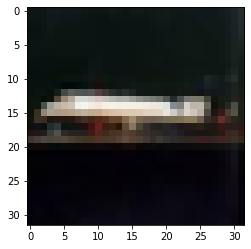

In [4]:
# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)

# check the data 
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('data shape:', example_data.shape)
print('label:', example_target)

check_image = example_data[0]
check_image = np.transpose(check_image, (1, 2, 0))

plt.figure()
plt.imshow(check_image)
plt.show()

# Model & Optimization and Loss function

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # for initializing nn.Module (parent class)
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(3, 16, 5), # number of input channel, number of output channel, kernel size   
            activation,          # we can set stride size and padding size. if we do not set the these parameters, default value is 1, 0.
            nn.Conv2d(16, 32,5),
            activation,
            max_pool,
            nn.Conv2d(32,64,5),
            activation,
            max_pool
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 100),
            activation,
            nn.Linear(100, 10)
        )
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) # [32, 64, 4, 4]
        flatten = extracted_feature.view(batch_size, -1) # [32, 64 * 4 * 4]
        result = self.classifier(flatten)
        return result

model = CNN().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

# Train & Test

In [6]:
loss_array = []

# train the model
for i in range(training_epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        loss_array.append(loss.cpu().detach().numpy())

0 epoch loss: 2.3065643310546875
10 epoch loss: 1.8361350297927856
20 epoch loss: 1.3765590190887451
30 epoch loss: 1.7374882698059082
40 epoch loss: 1.3921030759811401
50 epoch loss: 0.8418405652046204
60 epoch loss: 1.4103063344955444
70 epoch loss: 0.8594823479652405
80 epoch loss: 1.067651629447937
90 epoch loss: 0.739864706993103


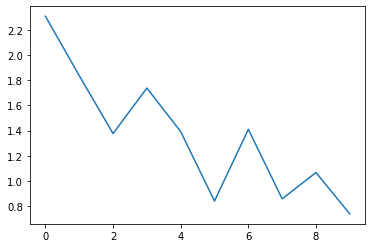

In [7]:
plt.figure()
plt.plot(loss_array)
plt.show()

In [8]:
#test the model
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for index, [data, label] in enumerate(test_loader):
        data = data.to(device)
        label = label.to(device)
        
        output = model.forward(data)
        _, prediction_index = torch.max(output, 1)
        
        prediction_list.append(prediction_index)
        label_list.append(label)
        
        total += label.size(0)
        correct += (prediction_index == label).sum().float()

    print("Accuracy of the model: {}".format(correct/total))

Accuracy of the model: 0.609375
